# Creating a Neural Network for Sentiment Classification



Text classification is the process of assigning tags or categories to text according to its content. It’s one of the fundamental tasks in natural language processing.

The text we want to classify is given as input to an algorithm and the algorithm will then analyze the text’s content, before finally categorizing the input as one of the tags or categories previously given.

Language and text can get very complicated which makes creating these algorithms difficult. Some things that make language difficult could be words that have multiple meanings, negation words (words such as not), slang, etc.

For this notebook, we'll stick with a binary classification problem - a given sentence will either have a positive or negative sentiment behind it. We'll dive further into the dataset in a later section, but we will be using IMDB movie reviews.

# Set up data and imports

## Library imports

In [3]:
!pip install -q tensorflow-hub
!pip install patool

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
import sys
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import libraries.mlvislib as mlvs

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

from IPython.core.display import HTML, display
# Initializing D3 for the entire notebook (this fixes error requiring kernel to load twice)
# (feel free to move this line to anywhere in notebook before visualizations)
display(HTML('<script data-require="d3@3.5.3" data-semver="3.5.3" src="//cdnjs.cloudflare.com/ajax/libs/d3/3.5.3/d3.js"></script>'))

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Load the dataset

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb), a file of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). You can find the original dataset on [imdb reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) or on [TensorFlow datasets](https://www.tensorflow.org/datasets). 

The dataset is already split up for us with the first 25,000 samples for training purposes and the latter 25,000 samples for testing. We will further break this down by saving 40% of the original training set for validation to ensure that our model is not overfitted (learning to only recognize our provided data) from our training data.

In [6]:
import ipywidgets as widgets
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import patoolib

# patoolib.extract_archive("dataset/IMDB Dataset.csv.zip", outdir='/dataset/')
dataset = pd.read_csv("dataset/IMDB Dataset.csv")
dataset = dataset[:25000]

dataset.isnull().values.any()
dataset.shape
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let's print the first 10 examples.

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
5    Probably my all-time favorite movie, a story o...
6    I sure would like to see a resurrection of a u...
7    This show was an amazing, fresh & innovative i...
8    Encouraged by the positive comments about this...
Name: review, dtype: object

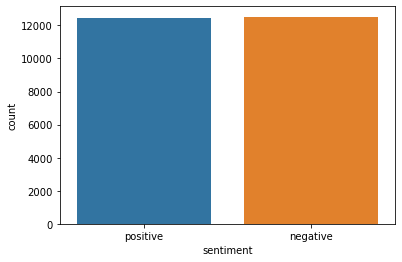

In [7]:
import seaborn as sns

sns.countplot(x='sentiment', data=dataset)
dataset["review"][:9]

This is where we'll split up our training set into a proper training set and a validation set.

In [8]:
from sklearn.model_selection import train_test_split

y = dataset['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

x_train, x_test, y_train, y_test = train_test_split(dataset['review'], y, test_size=0.4, random_state=42)

print(x_train)

18930    "Wired" would have to rate as one of the ten w...
2791     A 'Wes Craven presents' movie from 1995, direc...
388      A lovely little B picture with all the usual J...
22764    I am going to go out on a limb, and actually d...
24934    To put in simple words or rather a word, would...
                               ...                        
21575    I enjoyed a lot watching this movie. It has a ...
5390     I can't knock this film too terribly, because ...
860      This production was quite a surprise for me. I...
15795    This is a decent movie. Although little bit sh...
23654    Another very good Mann flick thanks to the fat...
Name: review, Length: 15000, dtype: object


## Build the model

Our model will still look like your typical neural network model with one new addition. Usually, there's some additional processing that has to occur in order for our sentences to be properly accepted by our model (vectorization, normalization, etc.) Another way that we can get around this is using a pre-trained layer that will embed our sentences for us. 


Our model will use a **pre-trained text embedding model** from [TensorFlow Hub](https://tfhub.dev) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).


You can view other options for [text embedding models](https://tfhub.dev/s?module-type=text-embedding) here. 

We'll first just build the embedded model itself:

In [9]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# universal_sentence_embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
# hub_layer = hub.KerasLayer(universal_sentence_embedding, input_shape=[], 
#                            dtype=tf.string, trainable=True)
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

And here's the rest of our model, complete with our standard loss and optimization functions.

In [10]:
# from keras.models import Sequential, Model
# from keras.layers.core import Activation, Dropout, Dense
# from keras.layers import Flatten
# from keras.layers import GlobalMaxPooling1D
# from keras.layers.embeddings import Embedding

# model = Sequential()
# model.add(hub_layer)
# 
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1))

# model.summary() 

model = tf.keras.Sequential([
    hub_layer,
    # Adjusting the below value will change the amount of 'bars' loaded into the Barcode Vis
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1'),
    tf.keras.layers.Dense(1, name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 48,197,257
Trainable params: 48,197,257
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

As always, after we've built our model the next step is to start training our model. 

Here, we define a callback function used to extact data from the model as it trains for use in a visualization later on in the notebook.

In [12]:
import libraries.extractioncallback as excb

extractor = excb.CallbackDataExtractor(
    model = model,
    layer = 1,
    validation_data = (x_test, y_test),
    rec_int_values = True,
    is_bin = True
)

In [13]:
history = model.fit(x_train, y_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2, shuffle=False, callbacks=[extractor])

Epoch 1/10
 6/24 [======>.......................] - ETA: 1s - loss: 0.6864 - accuracy: 0.4830WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0502s vs `on_train_batch_end` time: 0.0522s). Check your callbacks.


24/24 [==============================] - 4s 125ms/step - loss: 0.6648 - accuracy: 0.5085 - val_loss: 0.5757 - val_accuracy: 0.6617
Epoch 2/10
24/24 [==============================] - 3s 109ms/step - loss: 0.5313 - accuracy: 0.7014 - val_loss: 0.4491 - val_accuracy: 0.7747
Epoch 3/10
24/24 [==============================] - 3s 114ms/step - loss: 0.3687 - accuracy: 0.8403 - val_loss: 0.3664 - val_accuracy: 0.8283
Epoch 4/10
24/24 [==============================] - 3s 110ms/step - loss: 0.2406 - accuracy: 0.9055 - val_loss: 0.3343 - val_accuracy: 0.8480
Epoch 5/10
24/24 [==============================] - 3s 113ms/step - loss: 0.1565 - accuracy: 0.9432 - val_loss: 0.3307 - val_accuracy: 0.8540
Epoch 6/10
24/24 [==============================] - 3s 109ms/step - loss: 0.0990 - accuracy: 0.9703 - val_loss: 0.3441 - val_accuracy: 0.8540
Epoch 7/10
24/24 [==============================] - 3s 112ms/step - loss: 0.0633 - accuracy: 0.9857 - val_loss: 0.3565 - val_accuracy: 0.8577
Epoch 8/10
24/24 

In [14]:
# epoch_output = extractor.get_testing_results()

# extractor_predictions = extractor.get_stored_predictions()
# edited_predictions = []
# for epoch in extractor_predictions:
#     epoch_predictions = []
#     for item in epoch:
#         epoch_predictions.append((item > .5).astype("int32"))
#     edited_predictions.append(epoch_predictions)

# extractor.set_stored_predictions(edited_predictions)

Now we can start to see how our model performed by looking at a few different metrics.

In [15]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# make a prediction
testingPredictions = (model.predict(x_test) > 0.5).astype("int32")
confidence_scores = model.predict(x_test, batch_size=512)

# scaling confidence scores to range between 0 and 1 with MinMaxScaler 
scaler = MinMaxScaler(feature_range=[0, 1])
scaler.fit(confidence_scores)
confidence_scores = scaler.transform(confidence_scores)

target_names = ['negative', 'positive']
print(classification_report(y_test, testingPredictions, target_names=target_names))
testingPredictions

              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      5002
    positive       0.87      0.85      0.86      4998

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

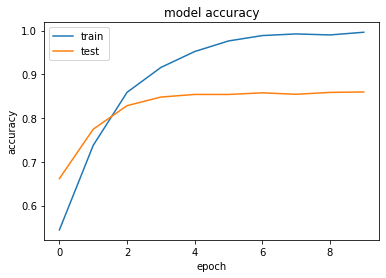

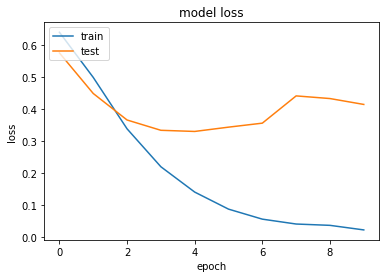

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Evaluate the model

After our model has been trained, the last step is to evaluate our model on our test data set.


In [17]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

313/313 - 1s - loss: 0.4100 - accuracy: 0.8604
loss: 0.410
accuracy: 0.860


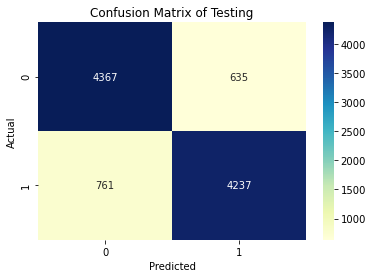

In [18]:
data = {'Actual':    y_test,
        'Predicted': testingPredictions.reshape(len(y_test),)
        }
#print(testingLabels.reshape(len(testingLabels),1))
df = pd.DataFrame(data, columns=['Actual','Predicted'])
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True,cmap="YlGnBu", fmt='d').set_title('Confusion Matrix of Testing')
plt.show()

In [19]:
epoch_output = extractor.get_testing_results()
# round(float(epoch_output[0]['confidence_score'][1][0]), 3)

In [20]:
import json
from IPython.core.display import HTML, display


# Writing Epoch Data to JSON...
output_directory = "libraries/stored_results"
output_filename = "sentiment_classification.json"
full_path = os.path.join(output_directory, output_filename)
display(HTML('<script data-require="d3@3.5.3" data-semver="3.5.3" src="//cdnjs.cloudflare.com/ajax/libs/d3/3.5.3/d3.js"></script>'))

    
# Revision of JSON writing...
data = {}
for i in range(len(epoch_output[0])):
    data[i] = {}
    data[i]['Num Epochs'] = len(epoch_output)
    data[i]['Index'] = i
    data[i]['Test Label'] = int(epoch_output[0]['actual'][i])
    data[i]['Test Prediction'] = {}
    data[i]['Test Confidence Score'] = {}
    data[i]['Intermediate Values'] = {}
    for j in range(len(epoch_output)):
        data[i]['Test Prediction'][j] = int(epoch_output[j]['prediction'][i][0])
        data[i]['Test Confidence Score'][j] = [round(float(epoch_output[j]['confidence_score'][i][0]), 3)]
        data[i]['Intermediate Values'][j] = epoch_output[j]['intermediate_values'][i]
    data[i]['Test Sentence'] = epoch_output[0]['input'][i]
    
    
with open(full_path, 'w') as outfile:
    json.dump(data, outfile, indent=4, sort_keys=False)

In [24]:
import libraries.mlvislib as mlvs
full_path = 'libraries/stored_results/sentiment_classification.json'

cm = mlvs.ConfusionMatrix(full_path, x_labels=["Negative", "Positive"], y_labels=["Positive", "Negative"])
cm.display()

In [22]:
import libraries.barcode as bc
full_path = 'libraries/stored_results/sentiment_classification.json'

bp = bc.BarcodePlot(full_path)
bp.display()